In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/To The Moon - From Reddit Comments to Stocks/Code/LSTMR"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/17-IViQXtJ7E70aIa03YJMvzoEf76guys/To The Moon - From Reddit Comments to Stocks/Code/LSTMR


In [ ]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [ ]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'num_comments', 'score', 'total_awards',
                          'author_commentkarma', 'compound_score', 'trustworthy', 'sw_1_author_trust',
                          'author_trust', 'author_id', 'author_name',
                          'ticker', 'post_type', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
                          'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 
                          'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
                          'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
                          'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
                          'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                          'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
                          'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
                          'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                          'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
                          'adjclose_21_Y'])

# Apply trust filter
df = df[(df["author_trust"] >= 0.8) & (df["trustworthy"] == 1)]

df

,post_id,date,num_comments,score,total_awards,author_commentkarma,compound_score,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,adjclose_17_X,adjclose_16_X,adjclose_15_X,adjclose_14_X,adjclose_13_X,adjclose_12_X,adjclose_11_X,adjclose_10_X,adjclose_9_X,adjclose_8_X,adjclose_7_X,adjclose_6_X,adjclose_5_X,adjclose_4_X,adjclose_3_X,adjclose_2_X,adjclose_1_X,adjclose_2_Y,adjclose_3_Y,adjclose_4_Y,adjclose_5_Y,adjclose_6_Y,adjclose_7_Y,adjclose_8_Y,adjclose_9_Y,adjclose_10_Y,adjclose_11_Y,adjclose_12_Y,adjclose_13_Y,adjclose_14_Y,adjclose_15_Y,adjclose_16_Y,adjclose_17_Y,adjclose_18_Y,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y,trustworthy,author_trust,sw_1_author_trust
3,ed0rg2j,2019-01-01,9,6,0.0,744.0,0.3612,2dk1wq99,nightman_123,WSBC,comment,38.873425,39.189323,38.214558,38.683891,38.115276,38.187477,38.061119,38.268715,38.377018,38.286758,37.330048,37.781326,37.573742,37.727173,38.115276,37.799374,37.582760,37.212711,37.095379,36.598965,33.853710,34.880959,34.944592,35.153675,35.180950,35.135498,34.962769,34.917316,35.162773,35.871841,36.108204,36.135464,35.799118,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271,1,0.888889,0.638215
92,ed2x6fn,2019-01-02,2,61,0.0,712.0,0.0516,rw1ynq0,martimook,CPSI,comment,25.979984,25.950769,25.882610,25.551525,25.006222,24.753046,24.840681,24.791990,24.889368,24.791990,24.889368,24.714090,25.093859,25.171459,26.626459,27.101759,27.392757,27.218159,26.131760,26.092960,24.869894,25.415201,25.814445,26.184475,26.340277,26.447390,26.272114,25.678120,25.863132,25.639170,26.476604,26.340277,25.989721,26.301327,26.496077,26.213688,25.619692,25.366512,25.347040,25.551525,1,0.800000,0.800000
100,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,ABCB,comment,41.132088,40.978432,41.199310,40.594284,41.449005,40.805569,40.776756,40.776756,42.150063,42.764690,42.755089,41.842751,42.697472,42.630238,42.630238,42.908749,42.140461,41.919582,41.612270,41.957993,30.676592,31.871288,33.133419,33.056339,33.239395,33.123787,33.538078,33.239395,33.152691,34.048706,34.588245,34.915821,34.241390,34.154694,33.981266,35.175957,36.235764,36.524799,36.476631,36.563339,1,0.857143,0.513544
101,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,CFFN,comment,12.528222,12.340834,12.314064,11.957135,11.957135,11.921442,11.823287,11.796516,11.894671,11.689439,11.466356,11.118350,11.101046,11.031827,11.066439,11.144307,11.057785,11.031827,10.832822,10.789560,11.725131,12.028520,11.974982,12.215910,12.046366,12.108830,12.046366,11.903595,11.948212,12.019599,12.108830,12.171293,12.206985,12.251601,12.135600,12.233756,12.198063,11.983905,11.609129,11.559727,1,0.857143,0.506293
120,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,FANG,comment,105.159828,106.703209,104.607254,104.645363,104.140427,99.919914,104.064209,103.587852,108.427612,108.903961,106.812767,103.453453,102.635025,104.899956,108.344917,105.299652,110.267235,107.888123,110.381439,108.792191,91.612320,95.204025,97.776329,99.986610,101.739594,101.110809,99.176819,99.567429,100.043777,100.643990,100.653511,101.834885,96.661659,96.537819,96.756943,97.376213,95.556526,95.423157,97.423836,98.243164,1,0.857143,0.513544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940494,ghkrh6s,2020-12-31,1,18,0.0,1283.0,0.3612,ihqbc,keikun2002,WSBC,comment,28.073952,29.172199,29.535013,30.162582,28.730938,28.191620,28.436766,28.417154,28.495598,28.417154,26.897259,25.985319,26.485415,27.583662,26.887453,22.994558,23.543680,22.612131,24.749790,24.337948,29.590624,29.828459,32.186985,32.097797,31.433842,31.770777,32.107712,31.612219,32.186985,31.394205,31.354565,31.205917,30.700518,31.364473,31.255468,30.720339,28.926668,29.550983,28.738380,29.313148,1,1.000000,0.443030
940516,ghmxpxm,2020-12-31,0,10,0.0,1283.0,-0.1295,ihqbc,keikun2002,WSB

In [ ]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'num_comments', 'score', 'total_awards',
       'author_commentkarma', 'compound_score', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y', 'trustworthy',
       'author_trust', 'sw_1_author_trust'], dtype=object)

In [ ]:
# Get the X-variable columns
df_X = df[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score', 'adjclose_20_X',
           'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
           'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
           'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
           'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
           'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X']]

# Get the Y-variable columns
df_Y = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y',
           'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y',
           'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
           'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y',
           'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y',
           '5day_min', '10day_min', '15day_min', '20day_min', '5day_max',
           '10day_max', '15day_max', '20day_max']]

# Clear up memory
del df
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

        num_comments  score  ...  adjclose_2_X  adjclose_1_X
3                  9      6  ...     37.095379     36.598965
92                 2     61  ...     26.131760     26.092960
100                0      2  ...     41.612270     41.957993
101                0      2  ...     10.832822     10.789560
120                0      2  ...    110.381439    108.792191
...              ...    ...  ...           ...           ...
821874             0      2  ...      1.140000      1.199998
821877             0      3  ...      3.090000      3.030000
821878             0      3  ...     11.770000     11.930000
821886             0      3  ...     30.790001     30.860001
821961             2      2  ...      2.480000      2.560000

[29262 rows x 25 columns]
        num_comments  score  ...  adjclose_2_X  adjclose_1_X
821972             0      1  ...     15.580000     14.250000
822057             1     36  ...     19.768454     19.219330
822065             1     16  ...     19.768454     19.2193

In [ ]:
print(X_train.shape)
print(X_test.shape)
red_train = X_train[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']].to_numpy()

print(red_train.shape)


red_test = X_test[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']].to_numpy()
print(red_test.shape)

X_train = X_train.drop(columns = ['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']).to_numpy()
print(X_train.shape)

X_test = X_test.drop(columns = ['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']).to_numpy()
print(X_test.shape)

(29262, 25)
(7316, 25)
(29262, 5)
(7316, 5)
(29262, 20)
(7316, 20)


In [ ]:
# Normalize data
scaler = MinMaxScaler()

n_features = 5

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)

print(xtrain_scale.shape)

#xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], xtrain_scale.shape[1], n_features)
xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], 4, n_features)

print(scaler.fit(X_test))
xval_scale=scaler.transform(X_test)
#xval_scale = xval_scale.reshape(xval_scale.shape[0], xval_scale.shape[1], n_features)
xval_scale = xval_scale.reshape(xval_scale.shape[0], 4, n_features)

print(scaler.fit(red_train))
red_train_scale = scaler.transform(red_train)
print(scaler.fit(red_test))
red_test_scale = scaler.transform(red_test)

print(scaler.fit(y_train))
ytrain_scale=scaler.transform(y_train)

print(scaler.fit(y_test))
yval_scale=scaler.transform(y_test)

# Set input and output dimensions
indim = xtrain_scale.shape[1]
outdim = ytrain_scale.shape[1]

#this dimension is for reddit data
input_dim = red_train_scale.shape[1]

# Predict
#ypred = model.predict(xval_scale)

# Scale back to original scale
#ypred = scaler.inverse_transform(ypred)

MinMaxScaler(copy=True, feature_range=(0, 1))
(29262, 20)
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

def create_mlp():
    model = Sequential()
    model.add(Dense(input_dim+1, input_dim=input_dim))
    # Hidden layer with ~sqrt(X_train.shape[0] = sqrt(188157))
    model.add(Dense(434))
    model.add(Dropout(0.2))
    return model

def create_lstm():
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=50, return_sequences=True, input_shape=(indim, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False, input_shape=(indim, n_features)))
    model.add(Dropout(0.2))
    # Output layer
    #model.add(Dense(434))
    return model

In [ ]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

mlp = create_mlp()
lstm = create_lstm()
combinedInput = Concatenate(axis=1)([mlp.output, lstm.output])
x = Dense(outdim)(combinedInput)
model = Model(inputs=[mlp.input, lstm.input], outputs=x)
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'mae'])

model.fit(x=[red_train_scale, xtrain_scale], y=ytrain_scale, epochs=10, batch_size=128, verbose = 0)

ypred = model.predict([red_test_scale,xval_scale])

# Scale back to original scale
ypred = scaler.inverse_transform(ypred)

In [ ]:
# Evaluate RMSE
rmse = mean_squared_error(y_test, ypred, multioutput='raw_values', squared=False)

# For each value in rmse
for i in range(1, len(rmse)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The RMSE for adjClose_{}_Y = ".format(i+1), rmse[i-1]**0.5)

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The RMSE for {}day_min = ".format((i-20)*5), rmse[i-1]**0.5)

    # Print the RMSE for max day
    else:
        print("The RMSE for {}day_max = ".format((i-24)*5), rmse[i-1]**0.5)

The RMSE for adjClose_2_Y =  31.995906018147664
The RMSE for adjClose_3_Y =  31.594491706934416
The RMSE for adjClose_4_Y =  32.77220627016533
The RMSE for adjClose_5_Y =  30.294870409207082
The RMSE for adjClose_6_Y =  30.697614968411596
The RMSE for adjClose_7_Y =  36.192385859836136
The RMSE for adjClose_8_Y =  36.23672925335105
The RMSE for adjClose_9_Y =  34.841514413510396
The RMSE for adjClose_10_Y =  40.1937927226259
The RMSE for adjClose_11_Y =  38.93485819189584
The RMSE for adjClose_12_Y =  41.14376996898127
The RMSE for adjClose_13_Y =  46.92783723089525
The RMSE for adjClose_14_Y =  49.463326140230826
The RMSE for adjClose_15_Y =  45.08981577190292
The RMSE for adjClose_16_Y =  46.90879653533723
The RMSE for adjClose_17_Y =  45.42181860903331
The RMSE for adjClose_18_Y =  44.73120332890631
The RMSE for adjClose_19_Y =  47.31467617205357
The RMSE for adjClose_20_Y =  49.222070169811445
The RMSE for adjClose_21_Y =  51.18930265008333
The RMSE for 5day_min =  1.58604618897802

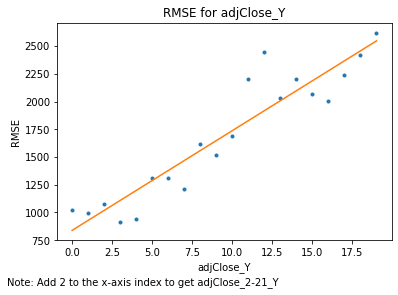

In [ ]:
# Plot the RMSE for adjClose
x = np.arange(20)
y = rmse[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('RMSE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()

In [ ]:
# Evaluate MAE
mae = mean_absolute_error(y_test, ypred, multioutput='raw_values')

# For each value in mae
for i in range(1, len(mae)+1):

    # Print the MAE values for adjClose
    if i < 21:
        print("The MAE for adjClose_{}_Y = ".format(i+1), mae[i-1])

    # Print the MAE values for min day
    elif 21 <= i < 25:
        print("The MAE for {}day_min = ".format((i-20)*5), mae[i-1])

    # Print the MAE for max day
    else:
        print("The MAE for {}day_max = ".format((i-24)*5), mae[i-1])

The MAE for adjClose_2_Y =  13.14627758662589
The MAE for adjClose_3_Y =  14.897828632749944
The MAE for adjClose_4_Y =  13.47062500940062
The MAE for adjClose_5_Y =  13.071876546067003
The MAE for adjClose_6_Y =  10.937191817402319
The MAE for adjClose_7_Y =  14.627301811675682
The MAE for adjClose_8_Y =  12.990205117813584
The MAE for adjClose_9_Y =  12.57306835700686
The MAE for adjClose_10_Y =  22.102413067863026
The MAE for adjClose_11_Y =  14.351990648183763
The MAE for adjClose_12_Y =  13.940952188452856
The MAE for adjClose_13_Y =  15.19269012659575
The MAE for adjClose_14_Y =  19.917591227669487
The MAE for adjClose_15_Y =  14.397302554465236
The MAE for adjClose_16_Y =  19.36246972515645
The MAE for adjClose_17_Y =  16.986643114169468
The MAE for adjClose_18_Y =  16.28285387972604
The MAE for adjClose_19_Y =  18.745285488505218
The MAE for adjClose_20_Y =  24.294662176289112
The MAE for adjClose_21_Y =  22.53971893044652
The MAE for 5day_min =  1.4121178465830686
The MAE for 

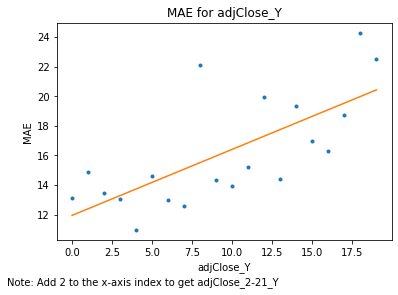

In [ ]:
# Plot the MAE for adjClose
x = np.arange(20)
y = mae[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('MAE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('MAE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()